# Лабораторная работа №4

ФИО:  **Киршин Дмитрий Игоревич**   
Группа: **БИВТ-20-2**  

Отправлять можно следующими способами (**обязательно указать свое ФИО и группу в каком-либо виде**):
1. Создать **приватный** репозиторий на github, добавить меня по нику (l3lush) в Collaborators (Settings -> Collaborators -> Add people)
2. Отправить заполненный ноутбук мне на почту avmysh@gmail.com, либо m1603956@edu.misis.ru
3. Отправить заполненный ноутбук мне в тг @l3lush. 

**Deadline**:
- hard -- **04.06.2023 23:59** (дедлайн теперь один)


**Что необходимо сделать** (можете вдохновляться ноутбуками для семинара, они должны помочь):
1. Загрузить датасет (вариант смотреть [здесь](https://docs.google.com/spreadsheets/d/1pFk1qZJtMrV8GWUmdSjV5Kz6JnFdBQDShErFZ337FDc/edit?usp=sharing))
2. Описать кратенько словами датасет, описать поставку задачи, что от чего отличаем, привести примеры картинок (картинки можно визуализировать после шага 3, когда у вас будет красивый датасет).
3. Оформить датасет в виде объекта класса Dataset из PyTorch (обязательно надо сделать препроцессинг данных: нормализовать данные, добавить аугментации к данным и пр.).
4. Оформить датасет из шага 3 в Dataloader.
5. Реализовать архитектуру собственной нейросети и натренировать ее на датасете (можно не обучать 1000 эпох, достаточно 10 эпох, но чтобы метрики начали улучшаться).
6. Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой вкус (список всех моделей, доступных в torchvision есть [тут](https://pytorch.org/vision/stable/models.html)).
7. Посчитать метрики качества финальной модели, сделать выводы.

**Замечание**  
Если понимаете, что данные слишком много весят, или с датасетом что-то не так, можете брать любой другой.  

P.S. Чтобы не ждать века, тренируйте модели на Colab с использованием GPU (Runtime -> Change runtime type -> GPU)  
P.S.S. Сохраняйте вывод ячеек и пушьте вместе с ним, в противном случае я не смогу нормально проверить все работы, если буду запускать все ноутбуки и ждать обучение моделей

# Объявление библиотек и загрузка датасета keremberke/shoe-classification

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.9 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset
dataset = load_dataset("keremberke/shoe-classification", name="full")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset shoe-classification downloaded and prepared to /root/.cache/huggingface/datasets/keremberke___shoe-classification/full/1.0.0/fb99532b93009eff01fb830c335a09fd117854f4d6933730a5b1c101c3fe2a32. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Описание датасета и постановка задачи. Картинки.

# keremberke/shoe-classification - это датасет, в котором хранятся изоображения пар обуви, относсящийся к одному из трех лейблов: Converse, Adidas или Nike. 
# Всего представлнено 825 картинок из которых:
  'train': 576, 'test': 83, 'valid': 166
#Основная задача - создать модель, которая будет относить обувь к одному из трёх лейблов.

In [7]:
map_of_labels = ['converse', 'adidas', 'nike']

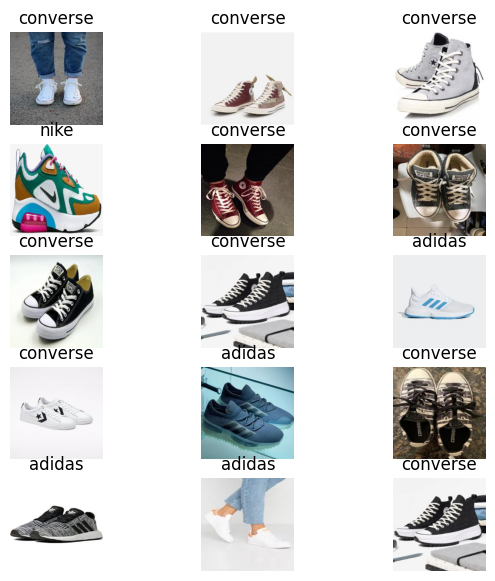

In [8]:
figure = plt.figure(figsize=(7, 7))
cols, rows = 3, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset['train']['image']), size=(1,)).item()
    img, label = dataset['train'][sample_idx]['image'], dataset['train'][sample_idx]['labels']
    figure.add_subplot(rows, cols, i)
    plt.title(map_of_labels[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

#Оформление датасета в виде объекта класса Dataset из PyTorch.

In [9]:
class NewDataset(Dataset):
  def __init__(self, data, transforms):
      self.data = data
      self.transform = transforms

  def __len__(self):
      return len(self.data)
  
  def __getitem__(self, idx):
      images = self.data[idx]['image'].convert('RGB')
      images = self.transform(images)
      labels = self.data[idx]['labels']

      return images, labels

In [13]:
apply_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((716, 375)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((716, 375)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((716, 375)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])
}

In [14]:
dataset_train = NewDataset(dataset['train'], apply_transforms['train'])
dataset_val = NewDataset(dataset['validation'], apply_transforms['validation'])
dataset_test = NewDataset(dataset['test'], apply_transforms['test'])

In [15]:
dataset = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

#Оформление измененного датасета из предыдущего шага в Dataloader.

In [16]:
dataloader_train = DataLoader(dataset['train'], batch_size=16, shuffle=True, num_workers=0)
dataloader_val = DataLoader(dataset['val'], batch_size=16, shuffle=True, num_workers=0)
dataloader_test = DataLoader(dataset['test'], batch_size=16, shuffle=False, num_workers=0)

In [17]:
dataloaders = {'train': dataloader_train, 'val': dataloader_val,'test': dataloader_test}

#Архитектура собственной нейросети и её тренировка.

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [19]:
def train_model(model, dataloader, criterion, optimizer, scheduler, epochs=18):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataset[phase])
            epoch_acc = running_corrects.double() / len(dataset[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [20]:
inputs, classes = next(iter(dataloaders['train']))

In [22]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, 2),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, stride=1),
    nn.Conv2d(16, 32, 3, 2, 1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(3, stride=2),
    nn.Conv2d(32, 128, 5, 2, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(3, stride=2),
    nn.Conv2d(128, 128, 3, 2, 1),
    nn.Flatten(),
    nn.Linear(7040, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 11)

)


out = model(inputs)
print(out.shape)
model = model.to(device)

torch.Size([16, 11])


In [23]:
criterion = nn.CrossEntropyLoss()
adam_optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(adam_optimizer, step_size=5, gamma=0.1)

In [24]:
model = train_model(model, dataloaders, criterion, adam_optimizer, scheduler, epochs=10)

Epoch 1/10
----------
train Loss: 1.2569 Acc: 0.4062
val Loss: 1.4773 Acc: 0.0904

Epoch 2/10
----------
train Loss: 1.0314 Acc: 0.4792
val Loss: 2.0061 Acc: 0.0000

Epoch 3/10
----------
train Loss: 0.9376 Acc: 0.5660
val Loss: 1.8200 Acc: 0.1084

Epoch 4/10
----------
train Loss: 0.8699 Acc: 0.6163
val Loss: 1.6834 Acc: 0.1386

Epoch 5/10
----------
train Loss: 0.8103 Acc: 0.6580
val Loss: 2.1464 Acc: 0.0542

Epoch 6/10
----------
train Loss: 0.6904 Acc: 0.7188
val Loss: 1.5273 Acc: 0.1988

Epoch 7/10
----------
train Loss: 0.5933 Acc: 0.7517
val Loss: 1.5240 Acc: 0.2169

Epoch 8/10
----------
train Loss: 0.5811 Acc: 0.7604
val Loss: 1.4438 Acc: 0.2892

Epoch 9/10
----------
train Loss: 0.5524 Acc: 0.7812
val Loss: 1.6258 Acc: 0.2229

Epoch 10/10
----------
train Loss: 0.5321 Acc: 0.7639
val Loss: 1.5363 Acc: 0.2530

Training complete in 1m 49s
Best val Acc: 0.289157


#Функции для определения метрик.

In [25]:
def all_accuracy(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 275 test images: {} %'.format(
        100 * correct / total))

In [26]:
def class_accuracy(net, testloader):
    class_correct = list(0. for i in range(11))
    class_total = list(0. for i in range(11))
    with torch.no_grad():
        for data in testloader:
            images, all_labels = data
            images, all_labels = images.cuda(), all_labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == all_labels).squeeze()
            for i in range(len(all_labels)):
                label = all_labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(11):
        if class_total[i] != 0:
          print('Accuracy of {} : {} %'.format(
              i, 100 * class_correct[i] / class_total[i]))

#Обучение модели с помощью Transfer Learning.

In [27]:
model_resnet = models.resnet50(pretrained=True)

model_resnet = model_resnet.to(device)
    
num_feats = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_feats, 11)

model_resnet.fc = model_resnet.fc.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]


In [28]:
criterion = nn.CrossEntropyLoss()
sgd_optimizer = optim.SGD(model_resnet.parameters(), lr=0.002, momentum=0.9, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(sgd_optimizer, step_size=4, gamma=0.1)

In [29]:
model_resnet = train_model(model_resnet, dataloaders ,criterion, sgd_optimizer, scheduler, epochs=10)

Epoch 1/10
----------
train Loss: 1.1324 Acc: 0.4931
val Loss: 3.6661 Acc: 0.0000

Epoch 2/10
----------
train Loss: 0.6562 Acc: 0.7448
val Loss: 1.6083 Acc: 0.2048

Epoch 3/10
----------
train Loss: 0.3154 Acc: 0.8715
val Loss: 0.5555 Acc: 0.7892

Epoch 4/10
----------
train Loss: 0.2101 Acc: 0.9288
val Loss: 0.7313 Acc: 0.6867

Epoch 5/10
----------
train Loss: 0.1102 Acc: 0.9757
val Loss: 0.8196 Acc: 0.6807

Epoch 6/10
----------
train Loss: 0.0820 Acc: 0.9844
val Loss: 0.5552 Acc: 0.7892

Epoch 7/10
----------
train Loss: 0.0754 Acc: 0.9809
val Loss: 0.8242 Acc: 0.6506

Epoch 8/10
----------
train Loss: 0.0544 Acc: 0.9983
val Loss: 0.5372 Acc: 0.8012

Epoch 9/10
----------
train Loss: 0.0579 Acc: 0.9948
val Loss: 0.5719 Acc: 0.7831

Epoch 10/10
----------
train Loss: 0.0739 Acc: 0.9809
val Loss: 0.6353 Acc: 0.7590

Training complete in 6m 26s
Best val Acc: 0.801205


#Выводы

In [30]:
all_accuracy(model, dataloaders['test'])

Accuracy of the network on the 275 test images: 80.72289156626506 %


In [31]:
all_accuracy(model_resnet, dataloaders['test'])

Accuracy of the network on the 275 test images: 91.56626506024097 %


In [32]:
class_accuracy(model, dataloaders['test'])

Accuracy of 0 : 84.21052631578948 %
Accuracy of 1 : 84.21052631578948 %
Accuracy of 2 : 42.857142857142854 %


In [33]:
class_accuracy(model_resnet, dataloaders['test'])

Accuracy of 0 : 97.36842105263158 %
Accuracy of 1 : 89.47368421052632 %
Accuracy of 2 : 71.42857142857143 %


#Анализируя данные метрик можно отметить, что модель, обученная с помощью Transfer Learning, является более точной, с результатом 91.5%, чем модель построенная на собственной архитектуре 80.7%.